# Analysis of Antibiotics Prescription and Hospitalisation Risk

In [283]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
# import sklearn
# from sklearn.model_selection import train_test_split
%matplotlib inline

In [284]:
#os.chdir("..")
current_working_dir = os.getcwd()
print(current_working_dir)

c:\Users\m84300af\OneDrive - The University of Manchester\Documents\GitHub\amr-uom-brit


In [285]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [286]:
def makeFilePath(pathFromWorkspace, fileName):
    workingdir = "/workspace/" if (os.name != "nt") else ""
    filepath = workingdir+pathFromWorkspace+fileName

    return filepath

In [287]:
# function to generate histogram plots
def create_histplot(title, df, ax):
    ax.hist(df, color = 'purple', edgecolor = 'black', bins=20)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=0)

In [288]:
def create_lineplot(var, title, legend_title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-03", color='black', ls='--', lw=1.5)

In [289]:
def create_lineplot_hue(var, hue, title, legend_title, ax1):
    a = data_inclusions_exlusions.groupby(['date', var, hue]).size().reset_index()
    a.columns = ['date', var, hue, 'Freq']
    a = a[a[var] != 0]
    sns.lineplot(x='date', y='Freq', 
            hue=hue, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-03", color='black', ls='--', lw=1.5)

## 1- Data Preparation

In [290]:
data2019_month = {}
data2020_month = {}
data2021_month = {}
data2019 = []
data2020 = []
data2021 = []
for  i in range(1, 13):
    # data of 2019
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2019-"+str(i).zfill(2)+"-01.csv.gz")
    data2019_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2019_month["%s" %i]['date'] = "2019-"+str(i).zfill(2)
    data2019.append(data2019_month["%s" %i])
    # data of 2020
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2020-"+str(i).zfill(2)+"-01.csv.gz")
    data2020_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2020_month["%s" %i]['date'] = "2020-"+str(i).zfill(2)
    data2020.append(data2020_month["%s" %i])
    # data of 2021
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2021-"+str(i).zfill(2)+"-01.csv.gz")
    data2021_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2021_month["%s" %i]['date'] = "2021-"+str(i).zfill(2)
    data2021.append(data2021_month["%s" %i])
    
data2019 = pd.concat(data2019_month, axis=0, ignore_index=True)
data2020 = pd.concat(data2020_month, axis=0, ignore_index=True)
data2021 = pd.concat(data2021_month, axis=0, ignore_index=True)

data = data2019.append([data2020, data2021], ignore_index=True)

In [291]:
data.describe(include='all')

,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,antibacterial_prescriptions_date,sgss_positive,primary_care_covid,covrx1_dat,covrx2_dat,...,hiv_comor,metastatic_cancer_comor,mild_liver_comor,mod_severe_liver_comor,mod_severe_renal_comor,mi_comor,peptic_ulcer_comor,peripheral_vascular_comor,patient_id,date
count,34200,3600,3600,3600,3600,99,3600,3600,0.0,0.0,...,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000
unique,36,36,36,13,7,29,1032,1036,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36
top,2021-10,2019-12,2019-08,2018-12,2018-12,2019-01-17,2020-11-23,2019-03-19,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01
freq,1045,129,124,319,626,8,11,11,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,5006.780083,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300004,0.300004,0.300004,0.300004,0.300004,0.300004,0.300004,0.300004,2883.089463,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2515.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5018.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7487.000000,NaN


In [292]:
data.columns

Index(['bmi_date_measured', 'smoking_status_date',
       'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med',
       'flu_vaccine_clinical', 'antibacterial_prescriptions_date',
       'sgss_positive', 'primary_care_covid', 'covrx1_dat', 'covrx2_dat',
       'admitted_date', 'died_date', 'uti_date_1', 'uti_date_2', 'uti_date_3',
       'uti_date_4', 'lrti_date_1', 'lrti_date_2', 'lrti_date_3',
       'lrti_date_4', 'age', 'age_cat', 'sex', 'practice', 'region', 'msoa',
       'imd', 'bmi', 'ethnicity', 'smoking_status', 'gp_count',
       'flu_vaccine_tpp', 'flu_vaccine', 'antibacterial_prescriptions',
       'antibacterial_brit', 'broad_spectrum_antibiotics_prescriptions',
       'admitted', 'uti_counts', 'lrti_counts', 'urti_counts',
       'sinusitis_counts', 'ot_externa_counts', 'otmedia_counts', 'uti_pt',
       'lrti_pt', 'urti_pt', 'sinusitis_pt', 'ot_externa_pt', 'otmedia_pt',
       'uti_ab_count_1', 'uti_ab_count_2', 'uti_ab_count_3', 'uti_ab_count_4',
       'lrti_ab_c

In [293]:
# define dictionaries

dict_sex = {'F': 'Female', 'M': 'Male'}
dict_ethnicity = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown', np.nan: 'Unknown'}
dict_smoking = {'E': 'Ex-smoker', 'M': 'Unknown', 'S': 'Smoker', 'N': 'Never smoked'}
dict_imd = {0: 'Unknown', 1: '1 (most deprived)', 2: '2', 3: '3', 4: '4', 5: '5 (least deprived)', np.nan: 'Unknown'}
dict_flu = {0: 'No', 1: 'Yes'}

In [294]:
# reoplace values of dictionaries with existing ones

data = data.replace({"sex": dict_sex})
data = data.replace({"ethnicity": dict_ethnicity})
data = data.replace({"smoking_status": dict_smoking})
data = data.replace({"imd": dict_imd})
data = data.replace({"flu_vaccine": dict_flu})

In [295]:
#prep before plot

data['age'][data['age'] < 0] = np.nan

## remove died cases
#data.died_date.value_counts()

# remove cases with bmi equal 0
data['bmi'][data['bmi'] <= 0] = np.nan

# remove cases with negative gp_count
data['gp_count'][data['gp_count'] < 0] = np.nan

# Negative GP consultations mean what? Shall I remove them?

#### Calculating Chalson Comorbidity Index
Based on: https://www.nature.com/articles/4500889.pdf?origin=ppub

In [296]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')

col18 = data.columns.get_loc('age')

In [297]:
for idx, x in enumerate(data['CCI']):
    n=0
    #comorbidity component
    if data.iat[idx, col15] == 1:
        n=n+1
    if data.iat[idx, col2] == 1:
        n=n+1 
    if data.iat[idx, col17] == 1:
        n=n+1 
    if data.iat[idx, col3] == 1:
        n=n+1
    if data.iat[idx, col7] == 1:
        n=n+1
    if data.iat[idx, col6] == 1:
        n=n+1
    if data.iat[idx, col16] == 1:
        n=n+1
    if data.iat[idx, col5] == 1:
        n=n+1
    if data.iat[idx, col12] == 1:
        n=n+1
    
    if data.iat[idx, col9] == 1:
        n=n+2
    if data.iat[idx, col14] == 1:
        n=n+2
    if data.iat[idx, col8] == 1:
        n=n+2
    if data.iat[idx, col1] == 1:
        n=n+2
    #if data.iat[idx, col5] == 1: # Leukaemia
    #    n=n+2
    #if data.iat[idx, col12] == 1: # Lymphoma
    #    n=n+2

    if data.iat[idx, col13] == 1:
        n=n+3

    if data.iat[idx, col11] == 1:
        n=n+6
    if data.iat[idx, col10] == 1:
        n=n+6

    #age component
    if data.iat[idx, col18] <= 40:
        n=n+0
    if data.iat[idx, col18] > 40 and data.iat[idx, col18] <= 50:
        n=n+1
    if data.iat[idx, col18] > 50 and data.iat[idx, col18] <= 60:
        n=n+2
    if data.iat[idx, col18] > 60 and data.iat[idx, col18] <= 70:
        n=n+3
    if data.iat[idx, col18] > 70:# and data.iat[idx, col18] <= 80:
        n=n+4
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

2.0     4793
3.0     4586
1.0     4307
4.0     4297
0.0     3362
5.0     3163
6.0     2848
7.0     2245
8.0     1757
9.0     1417
10.0    1108
11.0     715
12.0     491
13.0     384
14.0     191
15.0     138
16.0      86
17.0      50
18.0      31
19.0      19
20.0       7
21.0       4
22.0       1
Name: CCI, dtype: int64

In [298]:
data.age_cat

0         5-14
1          0-4
2        25-34
3        35-44
4        35-44
         ...  
35995    45-54
35996    35-44
35997    55-64
35998    25-34
35999    45-54
Name: age_cat, Length: 36000, dtype: object

In [299]:
# categorising 
data['BMI_cat'] = pd.cut(data['bmi'], right=False, bins=[0,18.5,25,30,200], labels=['Low', 'Moderate', 'High', 'very high'])
data['gp_count_cat'] = pd.cut(data['gp_count'], right=False, bins=[0,3,8,12,100], labels=['Few', 'Some', 'Many', 'Too many'])
data['CCI_cat'] = pd.cut(data['CCI'], right=False, bins=[0,1,3,5,7,99], labels=['No', 'Low', 'Moderate', 'High', 'Very high'])
data['Age_cat'] = pd.cut(data['age'], right=False, bins=[0,18,60,200], labels=['0-17 years', '18-59 years', '>59 years'])
#data.CCI_cat.value_counts()

## 2- Plots

### 2-1- Continuous factors

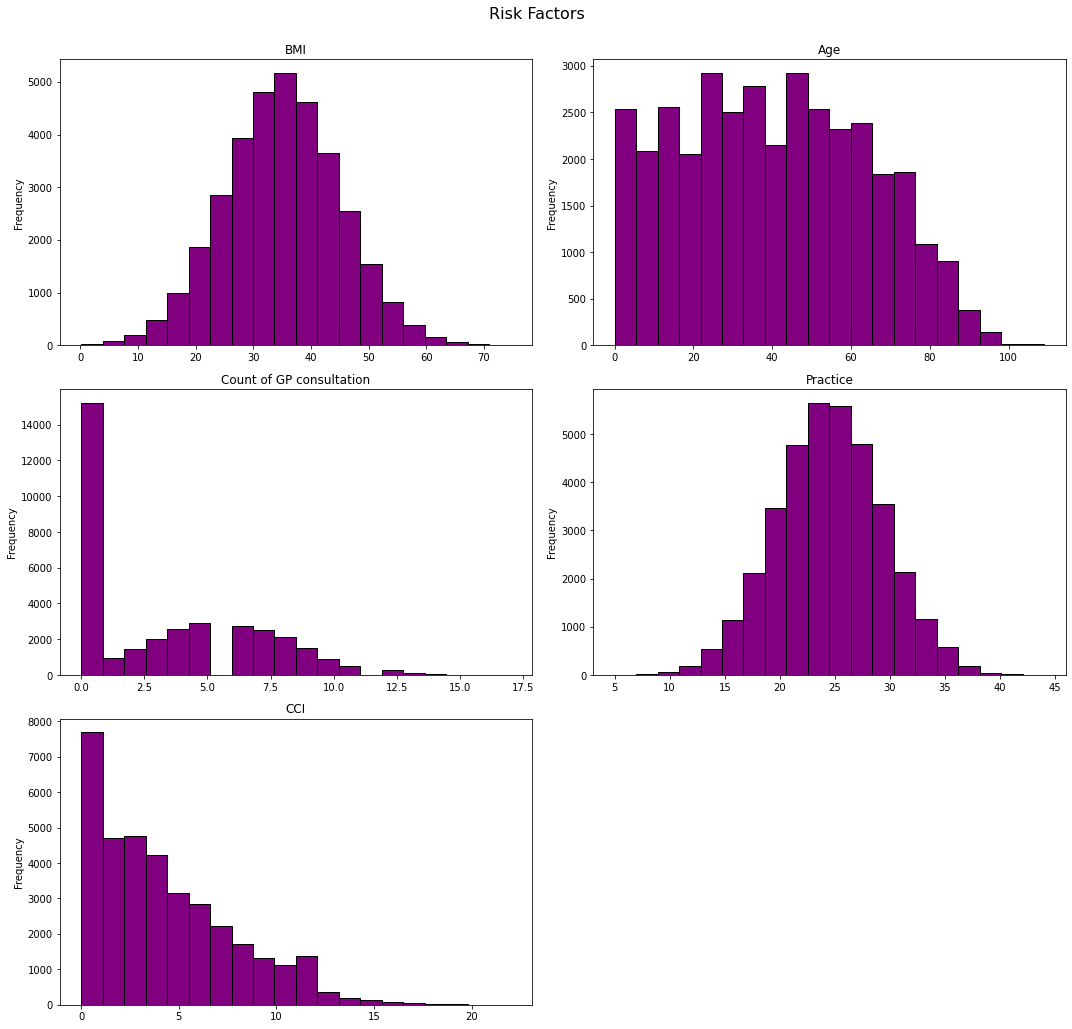

In [17]:
fig, axes = plt.subplots(3,2, 
                        figsize=(15, 15)
                        )
create_histplot('BMI', data['bmi'], axes[0,0])
create_histplot('Age', data['age'], axes[0,1])
create_histplot('Count of GP consultation', data['gp_count'], axes[1,0])
create_histplot('Practice', data['practice'], axes[1,1])
create_histplot('CCI', data['CCI'], axes[2,0])
fig.delaxes(ax=axes[2,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_risk/risk_factors_cont.jpg')
plt.show()

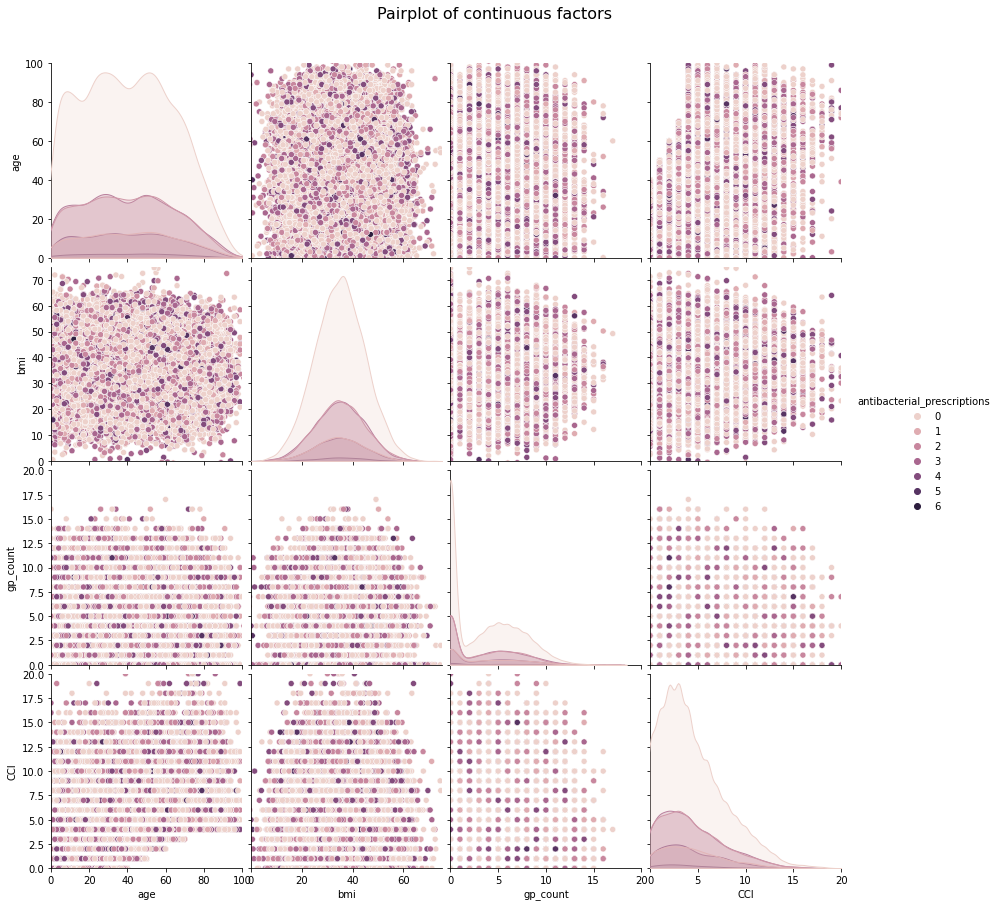

In [17]:
p = sns.pairplot(data, vars=['age', 'bmi', 'gp_count', 'CCI'#, 'practice'
                             ], 
                hue = 'antibacterial_prescriptions', 
#                kind='reg', 
                #markers=["o", "s"], 
                diag_kind="kde",#"hist"
#                plot_kws={#'line_kws':{'color':'red'}, 
#                'scatter_kws': {'alpha': 0.2}}, 
                height = 3)

p.axes[0,2].set_xlim((0,20))
p.axes[0,2].set_ylim((0,100))

p.axes[1,1].set_xlim((0,75))
p.axes[1,1].set_ylim((0,75))

p.axes[2,0].set_xlim((0,100))
p.axes[2,0].set_ylim((0,20))

p.axes[0,3].set_xlim((0,20))
p.axes[3,0].set_ylim((0,20))

plt.suptitle('Pairplot of continuous factors', fontsize=16, y=1.05)
plt.savefig('../output/hospitalisation_risk/risk_factors_cont_pairplot.jpg')
plt.show()

### 2-2- Categorical factors

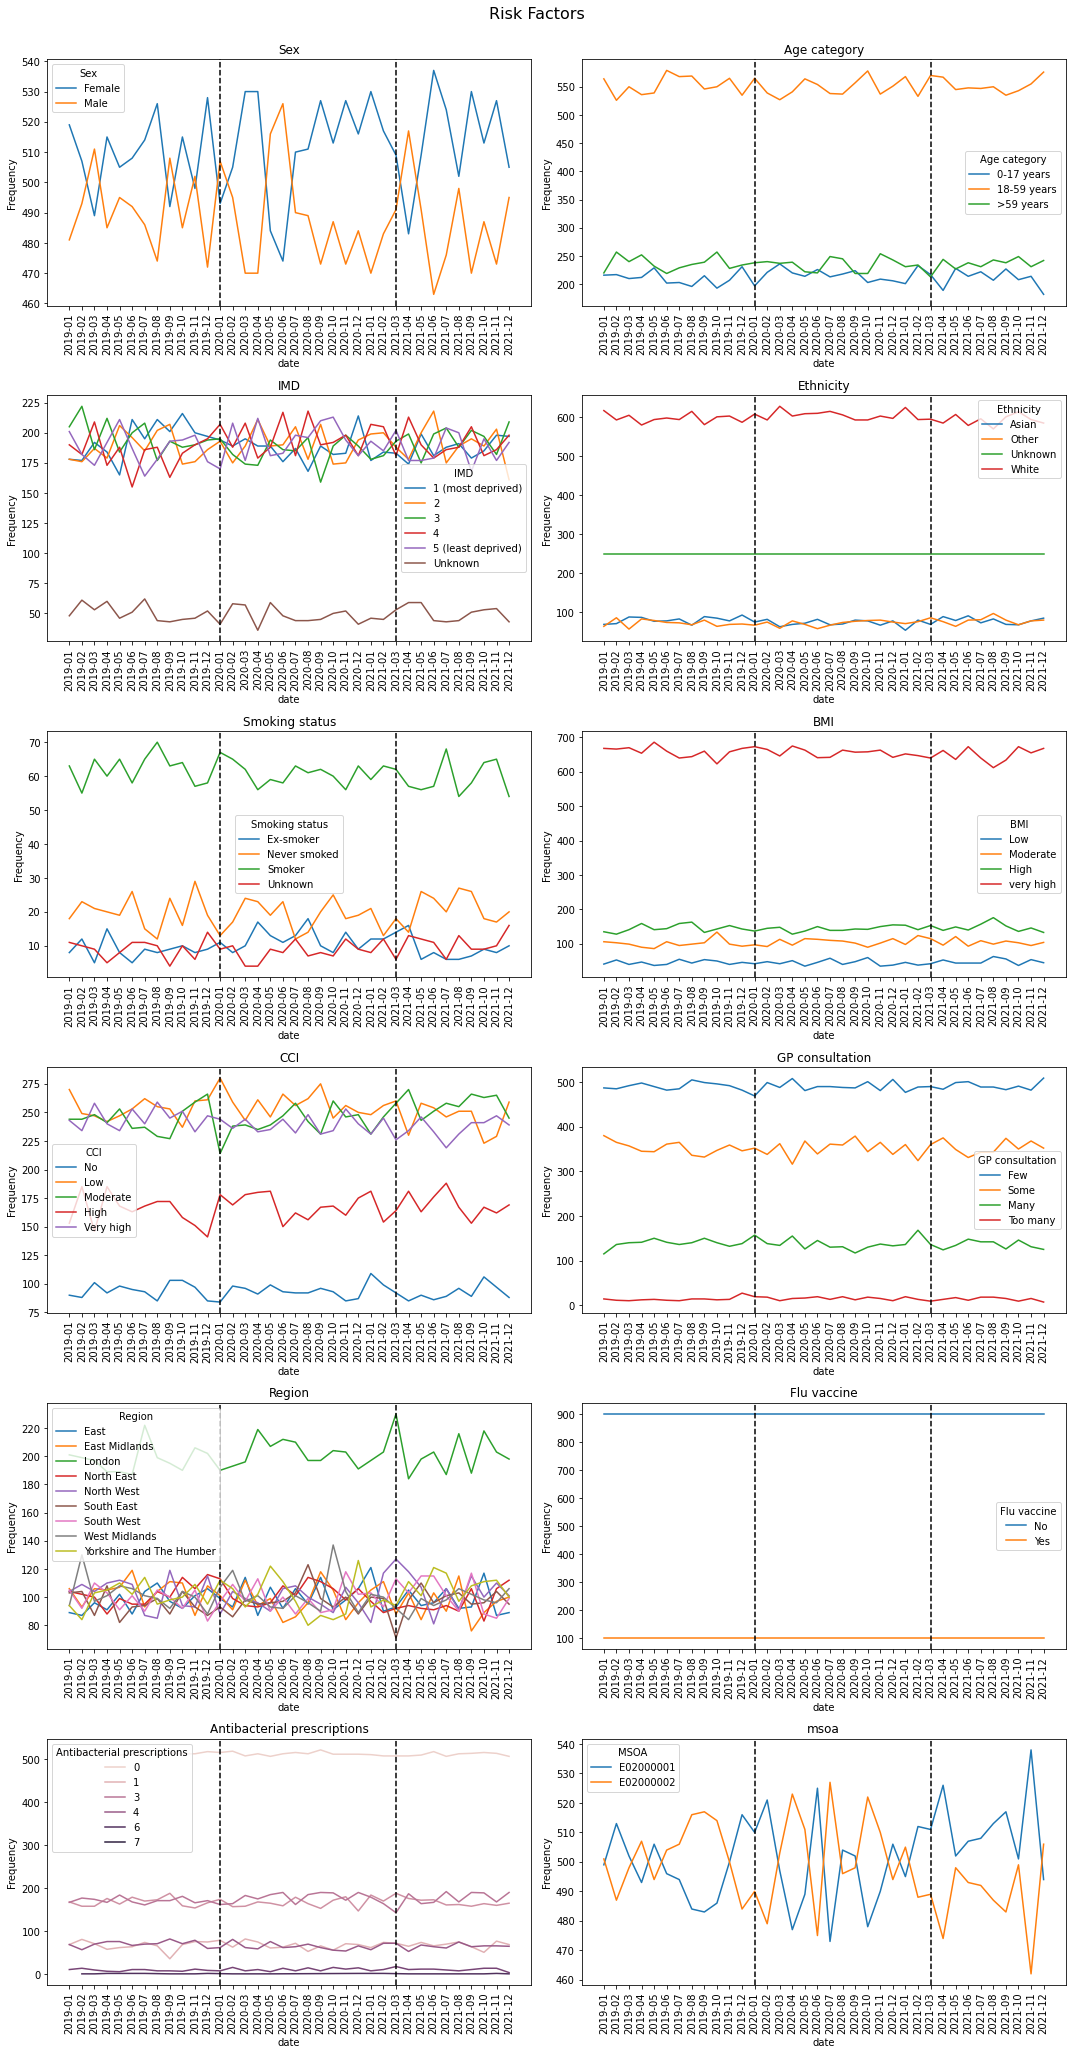

In [300]:
fig, axes = plt.subplots(6,2,
                        figsize=(15, 30)
                        )
create_lineplot('sex', 'Sex', 'Sex', axes[0,0])
create_lineplot('Age_cat', 'Age category', 'Age category', axes[0,1])
create_lineplot('imd', 'IMD', 'IMD', axes[1,0])
create_lineplot('ethnicity', 'Ethnicity', 'Ethnicity', axes[1,1])
create_lineplot('smoking_status', 'Smoking status', 'Smoking status', axes[2,0])
create_lineplot('BMI_cat', 'BMI', 'BMI', axes[2,1])
create_lineplot('CCI_cat', 'CCI', 'CCI', axes[3,0])
create_lineplot('gp_count_cat', 'GP consultation', 'GP consultation', axes[3,1])
create_lineplot('region', 'Region', 'Region', axes[4,0])
create_lineplot('flu_vaccine', 'Flu vaccine', 'Flu vaccine', axes[4,1])
create_lineplot('antibacterial_prescriptions', 'Antibacterial prescriptions', 'Antibacterial prescriptions', axes[5,0])
create_lineplot('msoa', 'msoa', 'MSOA', axes[5,1])
#fig.delaxes(ax=axes[4,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_risk/risk_factors_cat.jpg')
plt.show()

## 3- Hospital admissions related to infections 

### 3-1- Data preparation for hospital admission prediction with negative binomial regression
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission. 

In [301]:
data['uti_date_1'] = data['uti_date_1'].astype('datetime64[ns]')
data['uti_date_2'] = data['uti_date_2'].astype('datetime64[ns]')
data['uti_date_3'] = data['uti_date_3'].astype('datetime64[ns]')
data['uti_date_4'] = data['uti_date_4'].astype('datetime64[ns]')

data['lrti_date_1'] = data['lrti_date_1'].astype('datetime64[ns]')
data['lrti_date_2'] = data['lrti_date_2'].astype('datetime64[ns]')
data['lrti_date_3'] = data['lrti_date_3'].astype('datetime64[ns]')
data['lrti_date_4'] = data['lrti_date_4'].astype('datetime64[ns]')

data['primary_care_covid'] = data['primary_care_covid'].astype('datetime64[ns]')
data['sgss_positive'] = data['sgss_positive'].astype('datetime64[ns]')
data['admitted_date'] = data['admitted_date'].astype('datetime64[ns]')

In [302]:
data['delta_uti_1_admitted'] = (data['admitted_date'] - data['uti_date_1']).dt.days
data['delta_uti_2_admitted'] = (data['admitted_date'] - data['uti_date_2']).dt.days
data['delta_uti_3_admitted'] = (data['admitted_date'] - data['uti_date_3']).dt.days
data['delta_uti_4_admitted'] = (data['admitted_date'] - data['uti_date_4']).dt.days

data['delta_lrti_1_admitted'] = (data['admitted_date'] - data['lrti_date_1']).dt.days
data['delta_lrti_2_admitted'] = (data['admitted_date'] - data['lrti_date_2']).dt.days
data['delta_lrti_3_admitted'] = (data['admitted_date'] - data['lrti_date_3']).dt.days
data['delta_lrti_4_admitted'] = (data['admitted_date'] - data['lrti_date_4']).dt.days

In [303]:
data['delta_uti_1_admitted'] = data['delta_uti_1_admitted'][(data['delta_uti_1_admitted'] < 30) & (data['delta_uti_1_admitted'] > 0)]
data['delta_uti_2_admitted'] = data['delta_uti_2_admitted'][(data['delta_uti_2_admitted'] < 30) & (data['delta_uti_2_admitted'] > 0)]
data['delta_uti_3_admitted'] = data['delta_uti_3_admitted'][(data['delta_uti_3_admitted'] < 30) & (data['delta_uti_3_admitted'] > 0)]
data['delta_uti_4_admitted'] = data['delta_uti_4_admitted'][(data['delta_uti_4_admitted'] < 30) & (data['delta_uti_4_admitted'] > 0)]

data['delta_lrti_1_admitted'] = data['delta_lrti_1_admitted'][(data['delta_lrti_1_admitted'] < 30) & (data['delta_lrti_1_admitted'] > 0)]
data['delta_lrti_2_admitted'] = data['delta_lrti_2_admitted'][(data['delta_lrti_2_admitted'] < 30) & (data['delta_lrti_2_admitted'] > 0)]
data['delta_lrti_3_admitted'] = data['delta_lrti_3_admitted'][(data['delta_lrti_3_admitted'] < 30) & (data['delta_lrti_3_admitted'] > 0)]
data['delta_lrti_4_admitted'] = data['delta_lrti_4_admitted'][(data['delta_lrti_4_admitted'] < 30) & (data['delta_lrti_4_admitted'] > 0)]

In [304]:
data['Infection_count'] = np.nan
col0 = data.columns.get_loc('Infection_count')

col1 = data.columns.get_loc('delta_uti_1_admitted')
col2 = data.columns.get_loc('delta_uti_2_admitted')
col3 = data.columns.get_loc('delta_uti_3_admitted')
col4 = data.columns.get_loc('delta_uti_4_admitted')
col5 = data.columns.get_loc('delta_lrti_1_admitted')
col6 = data.columns.get_loc('delta_lrti_2_admitted')
col7 = data.columns.get_loc('delta_lrti_3_admitted')
col8 = data.columns.get_loc('delta_lrti_4_admitted')


for idx, x in enumerate(data['Infection_count']):
    n=0
    #comorbidity component
    if data.iat[idx, col1] > 0:
        n=n+1
    if data.iat[idx, col2] > 0:
        n=n+1 
    if data.iat[idx, col3] > 0:
        n=n+1 
    if data.iat[idx, col4] > 0:
        n=n+1
    if data.iat[idx, col5] > 0:
        n=n+1
    if data.iat[idx, col6] > 0:
        n=n+1
    if data.iat[idx, col7] > 0:
        n=n+1
    if data.iat[idx, col8] > 0:
        n=n+1
    data.iat[idx, col0]=n

data.Infection_count.value_counts()

# data.loc[data.Infection_count == 2]

0.0    35769
1.0      230
2.0        1
Name: Infection_count, dtype: int64

In [305]:
# add a column with the closest duration from hospitalisation
data['Infection_admitted_min_delta'] = data[['delta_uti_1_admitted','delta_uti_2_admitted', 'delta_uti_3_admitted', 
                                            'delta_uti_4_admitted', 'delta_lrti_1_admitted', 'delta_lrti_2_admitted',
                                            'delta_lrti_3_admitted', 'delta_lrti_4_admitted']].min(axis=1)

data['Infection_admitted_min_delta'].value_counts().sum()

231

In [306]:
print(f'Data shape is: {data.shape}')

Data shape is: (36000, 91)


In [307]:
# calculation of delta of hospital admission date and sgss diagnosis of covid
#data['delta_primary_care_covid_admitted'] = (data['admitted_date'] - data['primary_care_covid']).dt.days
data['delta_sgss_covid_admitted'] = (data['admitted_date'] - data['sgss_positive']).dt.days
data['delta_sgss_covid_admitted'].value_counts()

-35.0     4
 93.0     4
-119.0    4
 71.0     4
-2.0      4
         ..
-667.0    1
-333.0    1
-243.0    1
 983.0    1
 633.0    1
Name: delta_sgss_covid_admitted, Length: 749, dtype: int64

In [308]:
data['delta_sgss_covid_admitted'].value_counts().sum()

1026

In [309]:
data['delta_sgss_covid_admitted'] = data['delta_sgss_covid_admitted'][(data['delta_sgss_covid_admitted'] < 390) & (data['delta_sgss_covid_admitted'] > -390)]
data['delta_sgss_covid_admitted'].value_counts().sum()

631

In [310]:
# calculate absolute values for all rows in delta_primary_care_covid_admitted column
data['delta_sgss_covid_admitted_abs'] = data['delta_sgss_covid_admitted'].abs()

data['delta_sgss_covid_admitted_abs'].value_counts()

33.0     6
346.0    6
71.0     6
2.0      6
372.0    6
        ..
103.0    1
325.0    1
280.0    1
66.0     1
310.0    1
Name: delta_sgss_covid_admitted_abs, Length: 304, dtype: int64

In [311]:
data['delta_sgss_covid_admitted_abs'].value_counts().sum()

631

In [312]:
data['delta_sgss_covid_admitted_binary'] = data['delta_sgss_covid_admitted_abs'].mask(data['delta_sgss_covid_admitted_abs'] > 0, 1)
data['delta_sgss_covid_admitted_binary'] = data['delta_sgss_covid_admitted_binary'].fillna(0)
data['delta_sgss_covid_admitted_binary'].sum()
# data['delta_sgss_covid_admitted_binary'].value_counts()

631.0

In [313]:
data['delta_sgss_covid_admitted_binary'].value_counts()

0.0    35369
1.0      631
Name: delta_sgss_covid_admitted_binary, dtype: int64

In [314]:
#data.Infection_admitted_min_delta.value_counts()#.sum()

In [315]:
data.delta_sgss_covid_admitted_binary.value_counts()

0.0    35369
1.0      631
Name: delta_sgss_covid_admitted_binary, dtype: int64

In [316]:
data['Infection_admitted_min_delta_delta_sgss_covid_admitted_binary'] = np.nan
col0 = data.columns.get_loc('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary')

col1 = data.columns.get_loc('Infection_admitted_min_delta')
col2 = data.columns.get_loc('delta_sgss_covid_admitted_binary')


for idx, x in enumerate(data['Infection_admitted_min_delta_delta_sgss_covid_admitted_binary']):
    n=0
    #comorbidity component
    if data.iat[idx, col1] >= 1 and data.iat[idx, col2] == 1:
        n=n+1
    data.iat[idx, col0]=n

data['Infection_admitted_min_delta_delta_sgss_covid_admitted_binary'].value_counts()

# data.loc[data.Infection_count == 2]

0.0    35984
1.0       16
Name: Infection_admitted_min_delta_delta_sgss_covid_admitted_binary, dtype: int64

In [317]:
data.delta_sgss_covid_admitted_binary.value_counts()

0.0    35369
1.0      631
Name: delta_sgss_covid_admitted_binary, dtype: int64

### 3-2- Plots of hospitalisation

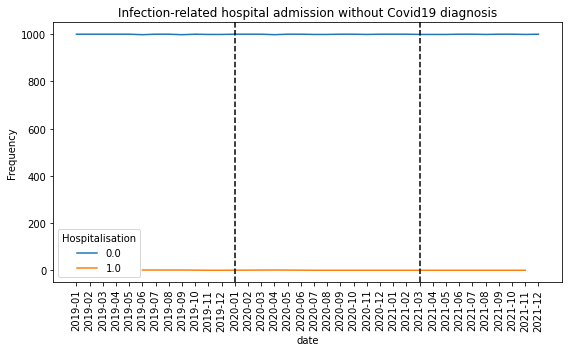

In [318]:
fig, ax = plt.subplots(figsize=(8, 5))

create_lineplot('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'Infection-related hospital admission without Covid19 diagnosis', 'Hospitalisation', ax)

plt.tight_layout()
plt.savefig('../output/hospitalisation_risk/infection-related_hospitalisation.jpg')
plt.show()

### 3-3- Data inclusions and exclusions

In [319]:
# inclusion applied
data_inclusions = data[data['Infection_admitted_min_delta'].notnull()]
print(f'The shape of data with hospitalisation inclusion criterion is: {data_inclusions.shape}')

The shape of data with hospitalisation inclusion criterion is: (231, 95)


In [320]:
# exclusion applied
data_inclusions_exlusions = data_inclusions[(data_inclusions['delta_sgss_covid_admitted'] < 390) & (data_inclusions['delta_sgss_covid_admitted'] > -390)]  # exclusions shold be <90  and >-30
print(f'The shape of data with hospitalisation inclusion criterion and covid diagnosis (sgss) exclusion criterion is: {data_inclusions_exlusions.shape}')

The shape of data with hospitalisation inclusion criterion and covid diagnosis (sgss) exclusion criterion is: (16, 95)


In [321]:
data_inclusions_exlusions['delta_sgss_covid_admitted'].value_counts()

-101.0    1
 127.0    1
-170.0    1
 128.0    1
 34.0     1
-300.0    1
-239.0    1
 75.0     1
-119.0    1
 182.0    1
-167.0    1
-181.0    1
 262.0    1
-33.0     1
-60.0     1
-67.0     1
Name: delta_sgss_covid_admitted, dtype: int64

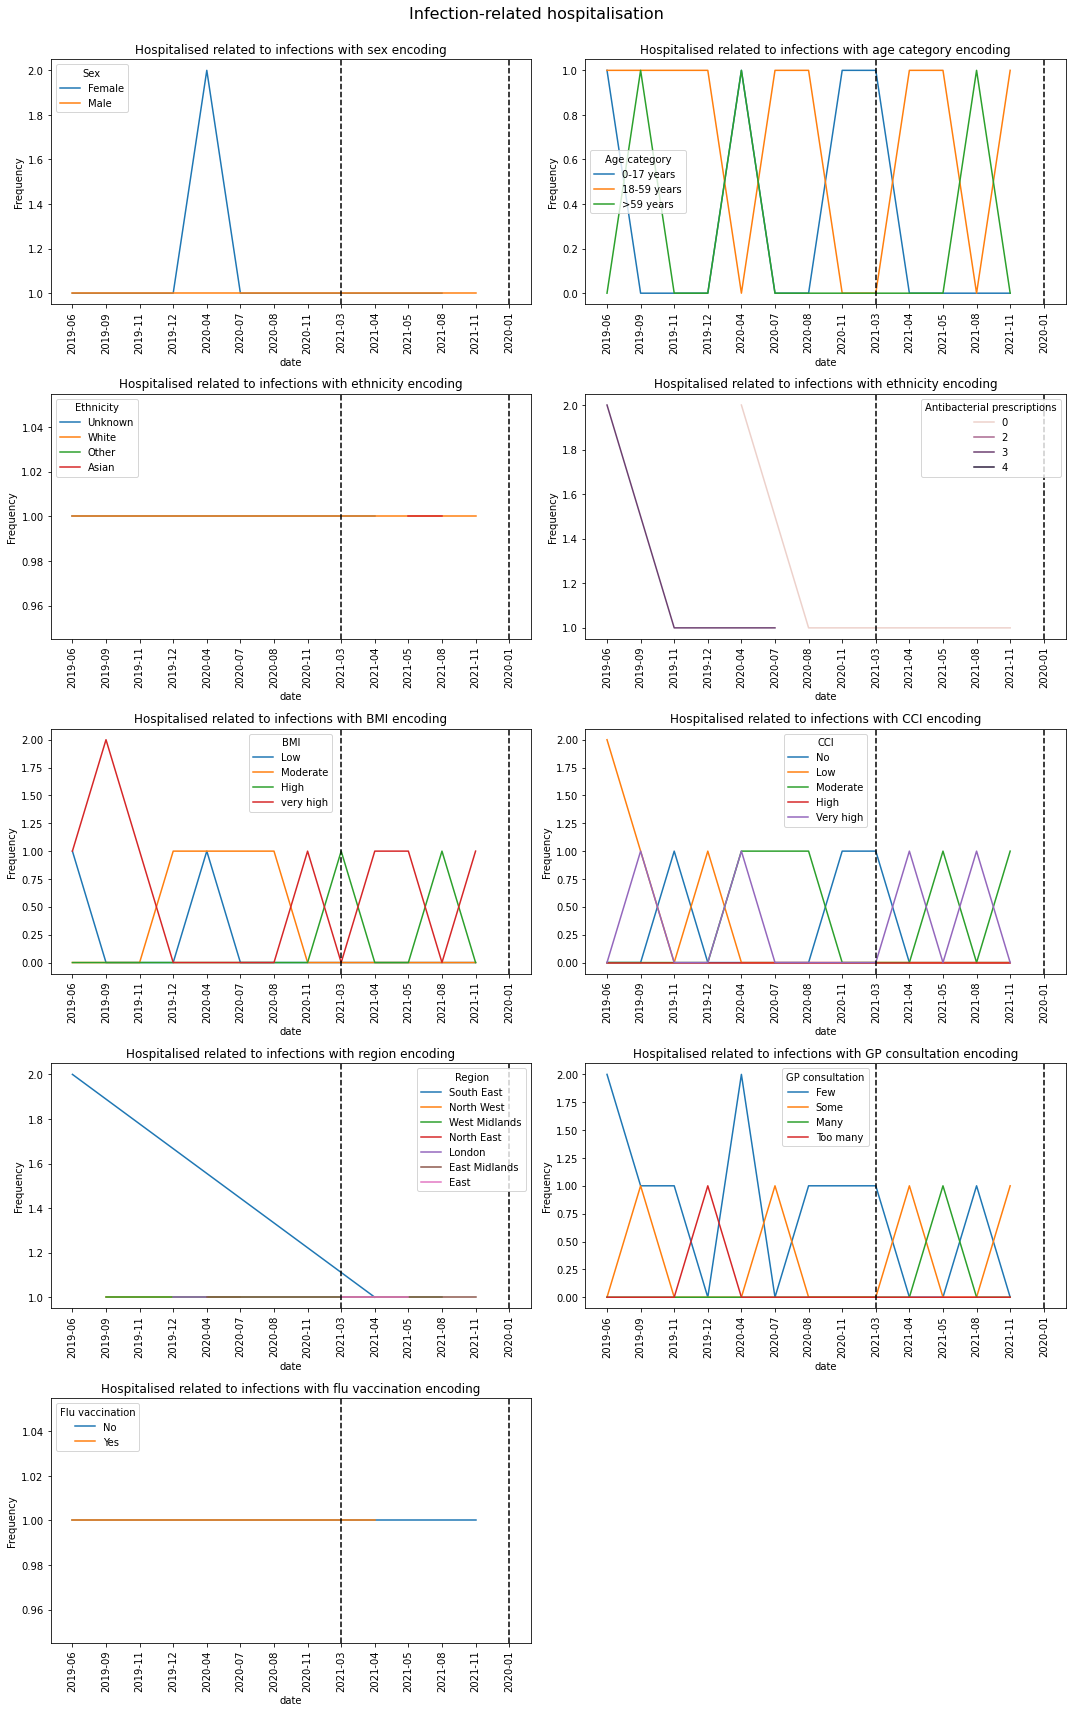

In [322]:
fig, axes = plt.subplots(5,2,
                        figsize=(15, 25)
                        )

create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'sex', 'Hospitalised related to infections with sex encoding', 'Sex', axes[0,0])
create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'Age_cat', 'Hospitalised related to infections with age category encoding', 'Age category', axes[0,1])
create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'ethnicity', 'Hospitalised related to infections with ethnicity encoding', 'Ethnicity', axes[1,0])
create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'antibacterial_prescriptions', 'Hospitalised related to infections with ethnicity encoding', 'Antibacterial prescriptions', axes[1,1])
create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'BMI_cat', 'Hospitalised related to infections with BMI encoding', 'BMI', axes[2,0])
create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'CCI_cat', 'Hospitalised related to infections with CCI encoding', 'CCI', axes[2,1])
create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'region', 'Hospitalised related to infections with region encoding', 'Region', axes[3,0])
create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'gp_count_cat', 'Hospitalised related to infections with GP consultation encoding', 'GP consultation', axes[3,1])
create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'flu_vaccine', 'Hospitalised related to infections with flu vaccination encoding', 'Flu vaccination', axes[4,0])
# create_lineplot_hue('delta_primary_care_covid_admitted_binary', 'covrx1_dat', 'Hospitalised related to infections with encoding of 1st Covid-19 Vaccine', '1st dose of Covid-19 vaccination', axes[5,0])
# create_lineplot_hue('delta_primary_care_covid_admitted_binary', 'covrx2_dat', 'Hospitalised related to infections with encoding of 2nd Covid-19 Vaccine', '2nd dose of Covid-19 vaccination', axes[5,1])
fig.delaxes(ax=axes[4,1])

fig.suptitle('Infection-related hospitalisation', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_risk/infection-related_hospitalisation_inclusion_exclusion_applied.jpg')
plt.show()

In [279]:
# # select patients whom their delta date is between 90 and -30
# data_hosp = data[~data['delta_primary_care_covid_admitted'].isnull()]
# data_hosp.head()

### 3-4- Negative binomial regression

In [323]:
data_inclusions_exlusions#['delta_primary_care_covid_admitted_abs']

,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,antibacterial_prescriptions_date,sgss_positive,primary_care_covid,covrx1_dat,covrx2_dat,...,delta_lrti_1_admitted,delta_lrti_2_admitted,delta_lrti_3_admitted,delta_lrti_4_admitted,Infection_count,Infection_admitted_min_delta,delta_sgss_covid_admitted,delta_sgss_covid_admitted_abs,delta_sgss_covid_admitted_binary,Infection_admitted_min_delta_delta_sgss_covid_admitted_binary
5359,2019-11,NaN,NaN,NaN,NaN,NaN,2020-06-14,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,6.0,-101.0,101.0,1.0,1.0
5772,2019-04,NaN,NaN,NaN,NaN,NaN,2020-05-15,NaT,NaN,NaN,...,18.0,NaN,NaN,NaN,1.0,18.0,127.0,127.0,1.0,1.0
8368,2019-12,2020-03,NaN,NaN,NaN,NaN,2020-11-02,NaT,NaN,NaN,...,NaN,19.0,NaN,NaN,1.0,19.0,-170.0,170.0,1.0,1.0
8850,2020-09,NaN,NaN,NaN,NaN,NaN,2020-12-10,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,5.0,128.0,128.0,1.0,1.0
10529,2019-12,NaN,NaN,NaN,2018-08,NaN,2019-06-09,NaT,NaN,NaN,...,NaN,15.0,NaN,NaN,1.0,15.0,34.0,34.0,1.0,1.0
11412,2021-05,NaN,NaN,NaN,NaN,NaN,2020-12-23,NaT,NaN,NaN,...,NaN,NaN,1.0,NaN,1.0,1.0,-300.0,300.0,1.0,1.0
15322,2020-10,NaN,NaN,NaN,NaN,NaN,2020-03-30,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,29.0,-239.0,239.0,1.0,1.0
15921,2020-08,NaN,NaN,NaN,NaN,NaN,2021-07-25,2021-02-07,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,17.0,75.0,75.0,1.0,1.0
18718,2021-09,NaN,NaN,NaN,NaN,NaN,2021-05-14,NaT,NaN,NaN,...,NaN,NaN,18.0,NaN,1.0,18.0,-119.0,119.0,1.0,1.0
19041,2021-08,NaN,NaN,NaN,NaN,NaN,2019-07-05,NaT,NaN,NaN,...,NaN,NaN,1.0,NaN,1.0,1.0,182.0,182.0,1.0,1.0


In [324]:
# # assigning 0 to NaN cells of delta_primary_care_covid_admitted_abs for compatibility of NB model
# data['delta_primary_care_covid_admitted_abs'] = data['delta_primary_care_covid_admitted_abs'].fillna(0)
# data['delta_primary_care_covid_admitted_abs'].value_counts()

In [325]:
# define dictionaries

# dict_sex = {'Female': 1, 'Male': 2}
# dict_ethnicity = {'White': 1, 'Mixed': 2, 'Asian': 3, 'Black': 4, 'Other': 5, 'Unknown': 0}
# dict_smoking = {'Ex-smoker': 1, 'Unknown': 2, 'Smoker': 3, 'Never smoked': 4, np.nan: 2}
dict_imd = {'Unknown': 0, '1 (most deprived)': 1, '2': 2, '3': 3, '4': 4, '5 (least deprived)': 5}
dict_flu = {'No': 0, 'Yes': 1}
#dic_delta_primary_care_covid_admitted_abs = {'No': 0, 'Yes': 1}

# reoplace values of dictionaries with existing ones

# data_inclusions_exlusions = data_inclusions_exlusions.replace({"sex": dict_sex})
# data_inclusions_exlusions = data_inclusions_exlusions.replace({"ethnicity": dict_ethnicity})
# data_inclusions_exlusions = data_inclusions_exlusions.replace({"smoking_status": dict_smoking})
data_inclusions_exlusions = data_inclusions_exlusions.replace({"imd": dict_imd})
data_inclusions_exlusions = data_inclusions_exlusions.replace({"flu_vaccine": dict_flu})

In [326]:
data_NB = data_inclusions_exlusions.groupby(['Infection_admitted_min_delta']).mean()#.reset_index()
#data_NB = data_NB.drop([0])
data_NB#.head()

,covrx1_dat,covrx2_dat,age,practice,imd,bmi,gp_count,flu_vaccine_tpp,flu_vaccine,antibacterial_prescriptions,...,delta_uti_4_admitted,delta_lrti_1_admitted,delta_lrti_2_admitted,delta_lrti_3_admitted,delta_lrti_4_admitted,Infection_count,delta_sgss_covid_admitted,delta_sgss_covid_admitted_abs,delta_sgss_covid_admitted_binary,Infection_admitted_min_delta_delta_sgss_covid_admitted_binary
Infection_admitted_min_delta,,,,,,,,,,,,,,,,,,,,,
1.0,NaN,NaN,53.500000,26.000000,3.500000,27.180287,4.75,0.0,0.0,0.5,...,NaN,1.0,NaN,1.0,NaN,1.0,-61.25,152.25,1.0,1.0
5.0,NaN,NaN,44.000000,19.000000,0.000000,31.716440,7.00,0.0,1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,1.0,128.00,128.00,1.0,1.0
6.0,NaN,NaN,8.000000,30.000000,4.000000,17.673710,0.00,0.0,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,1.0,-101.00,101.00,1.0,1.0
8.0,NaN,NaN,33.000000,25.000000,4.000000,60.887791,6.00,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,1.0,262.00,262.00,1.0,1.0
9.0,NaN,NaN,34.000000,27.000000,2.000000,30.723853,9.00,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,1.0,-33.00,33.00,1.0,1.0
15.0,NaN,NaN,37.000000,16.000000,5.000000,47.673765,0.00,0.0,0.0,3.0,...,NaN,NaN,15.0,NaN,NaN,1.0,34.00,34.00,1.0,1.0
17.0,NaN,NaN,9.666667,24.666667,2.333333,26.626646,0.00,0.0,0.0,0.0,...,NaN,17.0,NaN,NaN,NaN,1.0,-91.00,141.00,1.0,1.0
18.0,NaN,NaN,48.000000,22.000000,3.500000,34.814828,2.00,0.0,0.0,3.0,...,NaN,18.0,NaN,18.0,NaN,1.0,4.00,123.00,1.0,1.0
19.0,NaN,NaN,83.000000,33.000000,5.000000,32.266610,0.00,0.0,0.0,4.0,...,NaN,NaN,19.0,NaN,NaN,1.0,-170.00,170.00,1.0,1.0


In [327]:
data_NB.columns

Index(['covrx1_dat', 'covrx2_dat', 'age', 'practice', 'imd', 'bmi', 'gp_count',
       'flu_vaccine_tpp', 'flu_vaccine', 'antibacterial_prescriptions',
       'antibacterial_brit', 'broad_spectrum_antibiotics_prescriptions',
       'admitted', 'uti_counts', 'lrti_counts', 'urti_counts',
       'sinusitis_counts', 'ot_externa_counts', 'otmedia_counts', 'uti_pt',
       'lrti_pt', 'urti_pt', 'sinusitis_pt', 'ot_externa_pt', 'otmedia_pt',
       'uti_ab_count_1', 'uti_ab_count_2', 'uti_ab_count_3', 'uti_ab_count_4',
       'lrti_ab_count_1', 'lrti_ab_count_2', 'lrti_ab_count_3',
       'lrti_ab_count_4', 'cancer_comor', 'cardiovascular_comor',
       'chronic_obstructive_pulmonary_comor', 'heart_failure_comor',
       'connective_tissue_comor', 'dementia_comor', 'diabetes_comor',
       'diabetes_complications_comor', 'hemiplegia_comor', 'hiv_comor',
       'metastatic_cancer_comor', 'mild_liver_comor', 'mod_severe_liver_comor',
       'mod_severe_renal_comor', 'mi_comor', 'peptic_ulcer_c

In [328]:
X = data_NB[['age', 
#          'sex',
            'bmi',
#          'ethnicity', 
#          'smoking_status',
            'gp_count',
            'CCI',
            'imd',
            'flu_vaccine',
            'antibacterial_prescriptions',
#          'delta_primary_care_covid_admitted_abs',
          ]]
y = data_NB.index

In [329]:
nb2_training_results = sm.GLM(y, 
                              X,
                              family=sm.families.NegativeBinomial(alpha=1)).fit()

In [330]:
nb2_training_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   10
Model:                            GLM   Df Residuals:                        3
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36.303
Date:                Thu, 09 Dec 2021   Deviance:                       6.1541
Time:                        18:06:37   Pearson chi2:                     5.41
No. Iterations:                    17   Pseudo R-squ. (CS):            -0.1059
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
age                            -0.0005      0.067     -0.008      0.994      -0.132       0.130
bmi                             0.0483      0.038      1.262      0.207      -0.027       0.123
gp_count                       -0.0534      0.164     -0.325      0.745      -0.375       0.269
CCI                             0.0939      0.535      0.175      0.861      -0.955       1.143
imd                             0.1730      0.374      0.462      0.644      -0.560       0.906
flu_vaccine                    -0.1628      2.006     -0.081      0.935      -4.094       3.768
antibacterial_prescriptions     0.0460      0.662      0.069      0.945      -1.252       1.344
===============================================================================================
"""

In [331]:
# nb2_training_results.summary2()

In [332]:
nb2_training_results.conf_int()

,0,1
age,-0.131542,0.130492
bmi,-0.026741,0.123346
gp_count,-0.375387,0.268646
CCI,-0.955374,1.143199
imd,-0.560230,0.906190
flu_vaccine,-4.094007,3.768468
antibacterial_prescriptions,-1.252308,1.344295


In [333]:
err_series = nb2_training_results.params - nb2_training_results.conf_int()[0]
err_series

age                            0.131017
bmi                            0.075043
gp_count                       0.322017
CCI                            1.049286
imd                            0.733210
flu_vaccine                    3.931237
antibacterial_prescriptions    1.298301
dtype: float64

In [334]:
coef_df = pd.DataFrame({'coef': nb2_training_results.params.values[0:],
                        'err': err_series.values[0:],
                        'varname': err_series.index.values[0:]
                       })
coef_df

,coef,err,varname
0,-0.000525,0.131017,age
1,0.048302,0.075043,bmi
2,-0.053371,0.322017,gp_count
3,0.093912,1.049286,CCI
4,0.172980,0.733210,imd
5,-0.162770,3.931237,flu_vaccine
6,0.045993,1.298301,antibacterial_prescriptions


##### 3-4-1- Plot effect of predictors

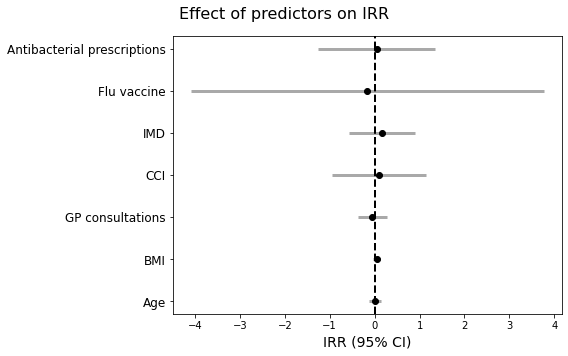

In [336]:
fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle('Effect of predictors on IRR', fontsize=16)
ax.errorbar(x=coef_df['coef'], y=coef_df['varname'], xerr=coef_df['err'], fmt='o', color='black',
             ecolor='darkgray', elinewidth=3)
# ax1.set_title('variable, asymmetric error')
# ax1.set_yscale('log')
ax.axvline(x=0, linestyle='--', color='black', linewidth=2)
#ax.xaxis.set_ticks_position('none')
_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
                       rotation=0, fontsize=12)

plt.xlabel('IRR (95% CI)', fontsize='14')
# plt.ylim(0,10)
plt.tight_layout()
plt.savefig('../output/hospitalisation_risk/effect_IRR.jpg')
plt.show()

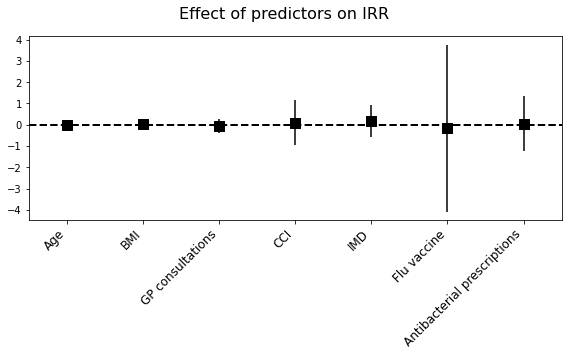

In [337]:
fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle('Effect of predictors on IRR', fontsize=16)
coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=2)
#ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
                       rotation=45, fontsize=12, ha='right')

plt.tight_layout()
plt.savefig('../output/hospitalisation_risk/effect_IRR_vert.jpg')
plt.show()

##### 3-4-2- Plot predictions and actual values

In [338]:
# nb2_predictions = nb2_training_results.get_prediction(X_test)
nb2_predictions = nb2_training_results.get_prediction(X)

In [339]:
nb2predictions_summary_frame = nb2_predictions.summary_frame()
print(nb2predictions_summary_frame)

                                   mean    mean_se  mean_ci_lower  \
Infection_admitted_min_delta                                        
1.0                            8.608380   5.891055       2.251181   
5.0                            3.835528   4.170512       0.455284   
6.0                            5.498265   5.940331       0.661587   
8.0                           44.256457  41.556688       7.025881   
9.0                            5.020555   4.548390       0.850360   
15.0                          26.741096  24.700565       4.374518   
17.0                           6.109755   3.159105       2.217697   
18.0                          11.952322   5.882902       4.555049   
19.0                          25.059000  24.424219       3.709577   
29.0                          19.227246  18.905840       2.798623   

                              mean_ci_upper  
Infection_admitted_min_delta                 
1.0                               32.917916  
5.0                              

In [340]:
#X = X.apply(lambda x: x.sort_values(ascending=False))
#X

In [341]:
#X['delta_primary_care_covid_admitted_abs'] = data_NB['delta_primary_care_covid_admitted_abs'].loc[X.index]

In [342]:
X

,age,bmi,gp_count,CCI,imd,flu_vaccine,antibacterial_prescriptions
Infection_admitted_min_delta,,,,,,,
1.0,53.500000,27.180287,4.75,5.250000,3.500000,0.0,0.5
5.0,44.000000,31.716440,7.00,2.000000,0.000000,1.0,4.0
6.0,8.000000,17.673710,0.00,2.000000,4.000000,1.0,3.0
8.0,33.000000,60.887791,6.00,7.000000,4.000000,1.0,0.0
9.0,34.000000,30.723853,9.00,3.000000,2.000000,0.0,0.0
15.0,37.000000,47.673765,0.00,0.000000,5.000000,0.0,3.0
17.0,9.666667,26.626646,0.00,1.333333,2.333333,0.0,0.0
18.0,48.000000,34.814828,2.00,2.000000,3.500000,0.0,3.0
19.0,83.000000,32.266610,0.00,7.000000,5.000000,0.0,4.0


In [343]:
NB_predicted_counts=nb2predictions_summary_frame['mean']
NB_predicted_counts

Infection_admitted_min_delta
1.0      8.608380
5.0      3.835528
6.0      5.498265
8.0     44.256457
9.0      5.020555
15.0    26.741096
17.0     6.109755
18.0    11.952322
19.0    25.059000
29.0    19.227246
Name: mean, dtype: float64

In [344]:
y

Float64Index([1.0, 5.0, 6.0, 8.0, 9.0, 15.0, 17.0, 18.0, 19.0, 29.0], dtype='float64', name='Infection_admitted_min_delta')

In [345]:
X#.index

,age,bmi,gp_count,CCI,imd,flu_vaccine,antibacterial_prescriptions
Infection_admitted_min_delta,,,,,,,
1.0,53.500000,27.180287,4.75,5.250000,3.500000,0.0,0.5
5.0,44.000000,31.716440,7.00,2.000000,0.000000,1.0,4.0
6.0,8.000000,17.673710,0.00,2.000000,4.000000,1.0,3.0
8.0,33.000000,60.887791,6.00,7.000000,4.000000,1.0,0.0
9.0,34.000000,30.723853,9.00,3.000000,2.000000,0.0,0.0
15.0,37.000000,47.673765,0.00,0.000000,5.000000,0.0,3.0
17.0,9.666667,26.626646,0.00,1.333333,2.333333,0.0,0.0
18.0,48.000000,34.814828,2.00,2.000000,3.500000,0.0,3.0
19.0,83.000000,32.266610,0.00,7.000000,5.000000,0.0,4.0


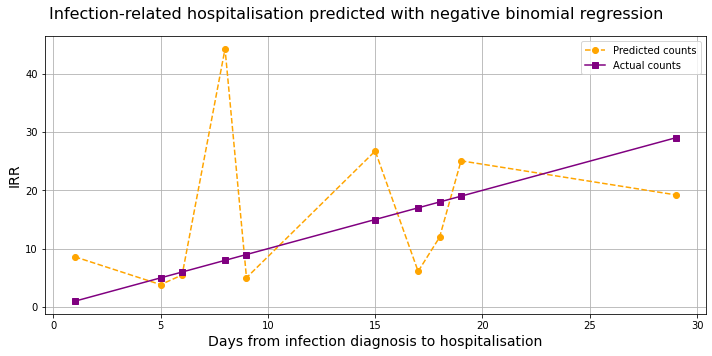

In [347]:
# ignore actual and predicted values in row 0
# NB_predicted_counts = nb2predictions_summary_frame['mean'].drop([0])*1000
NB_predicted_counts = nb2predictions_summary_frame['mean']#*1000
# actual_counts = y.drop([0])*1000
actual_counts = y#*1000

fig = plt.figure(figsize=(10, 5))
fig.suptitle('Infection-related hospitalisation predicted with negative binomial regression', fontsize=16)
predicted, = plt.plot(X.index, NB_predicted_counts, color='orange', ls='dashed', marker='o', label='Predicted counts',
                    #'go--', 
                    )
actual, = plt.plot(X.index, actual_counts, color='purple', ls='solid', marker='s', label='Actual counts'
                    #'ro-', 
                    )
#plt.ylim(-0.1,1.1)

# plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
# plt.axvline(x="2021-03", color='black', ls='--', lw=1.5)

plt.legend(handles=[predicted, actual])
# plt.xticks(rotation=90,) 
#             #ha='right')
plt.grid()
plt.ylabel('IRR', fontsize='14')
plt.xlabel('Days from infection diagnosis to hospitalisation', fontsize='14')
# plt.ylim(0,10)
plt.tight_layout()
plt.savefig('../output/hospitalisation_risk/NB2_hosp.jpg')
plt.show()

##### 3-4-3- Other plots

In [ ]:
# # see: https://www.statsmodels.org/dev/generated/statsmodels.genmod.generalized_linear_model.GLMResults.html

# # added variable plot for a fitted regression model
# nb2_training_results.plot_added_variable('age')

# nb2_training_results.plot_ceres_residuals('age')

# nb2_training_results.plot_partial_residuals('age')

In [348]:
# # #Influence Measures for GLM Logit
# # #https://www.statsmodels.org/stable/examples/notebooks/generated/influence_glm_logit.html

# NB2 = nb2_training_results.get_influence(observed=False)

# NB2_sum = NB2.summary_frame()
# NB2_sum.sort_values("cooks_d", ascending=False)[:10]

# # fig = NB2.plot_influence()
# # fig.tight_layout(pad=1.0)

# # fig = NB2.plot_index(y_var="cooks", threshold=2 * infl.cooks_distance[0].mean())
# # fig.tight_layout(pad=1.0)

# # fig = NB2.plot_index(y_var="resid", threshold=1)
# # fig.tight_layout(pad=1.0)

# # fig = NB2.plot_index(y_var="dfbeta", idx=1, threshold=0.5)
# # fig.tight_layout(pad=1.0)

# # fig = NB2.plot_index(y_var="dfbeta", idx=2, threshold=0.5)
# # fig.tight_layout(pad=1.0)

## Questions:
Q1- should we not exclude those who are admitted due to covid, not those who were diagnosed with covid 3 months before or two weeks after?

Q2- what is the difference between primary_care_covid and sgss_positive? seems like the first one is broader, right?

Q3- Data for NB2 model is not split into training and testing. Is it OK or it should be split?

Q4- I have used groupby to create data set for NB2. It calculates a mean value for each variable in each month. How is this gonna work with categorical variables?

Q5- If a patient gets hospitalise twice or more, I assume we consider the one that was closer to the infection diagnosis date, right?